In [3]:
# install packages
import Pkg
Pkg.activate(".")
Pkg.add("Agents")
Pkg.add("Plots")
Pkg.instantiate()

  Activating project at `/workspaces/agentsjl/notebooks`


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `/workspaces/agentsjl/notebooks/Project.toml`
  No Changes to `/workspaces/agentsjl/notebooks/Manifest.toml`


   Resolving package versions...


  No Changes to `/workspaces/agentsjl/notebooks/Project.toml`
  No Changes to `/workspaces/agentsjl/notebooks/Manifest.toml`


In [6]:
using Agents

mutable struct WealthInSpace <: AbstractAgent
    id::Int
    pos::NTuple{2,Int}
    wealth::Int
end

function agent_step_2d!(agent, model)
    agent.pos = random_nearby_position(agent.pos, model)
    available_ids = ids_in_position(agent.pos, model)
    available_ids = filter(x -> x != agent.id, available_ids)
    if length(available_ids) > 0 && agent.wealth > 0
        random_neighbor_agent = model[rand(model.rng, available_ids)]
        agent.wealth -= 1
        random_neighbor_agent.wealth += 1
    end
end

function wealth_model_2D(; dims = (10, 10), wealth = 1, M = 100)
    space = GridSpace(dims, periodic = true)
    model = ABM(WealthInSpace, space; scheduler = Schedulers.randomly)
    for i in 1:M # add agents in random positions
        add_agent!(model, wealth)
    end
    return model
end

model2D = wealth_model_2D()

function gini(model)
    wealth = [agent.wealth for agent in allagents(model)]
    n = length(wealth)
    if n == 0
        return 0
    end
    mean_wealth = sum(wealth) / n
    sum_wealth_diff = sum(abs.(wealth .- mean_wealth))
    gini = sum_wealth_diff / (2 * n * mean_wealth)
    return gini
end

gini (generic function with 1 method)

In [7]:
sizes = [10, 20, 50, 100]
agents = [100, 500, 1000, 5000]
iterations = 5
steps = 100

for size in sizes
    for agent in agents
        itime = time() 
        for i in 1:iterations
            model = wealth_model_2D(dims = (size, size), M = agent)
            for j in 1:steps
                step!(model, agent_step_2d!)
            end
            push!(ginis, gini(model))
        end
        println("Size: ", size, " Agents: ", agent, " Time: ", time() - itime)
    end
end

model = wealth_model_2D(2)
adata = [:wealth, :pos]
adata, mdata = run!(model, agent_step_2d!, 10; adata = adata, mdata = [gini])
mdata

Row,step,gini
,Int64,Float64
1,0,0.0
2,1,0.32
3,2,0.4
4,3,0.47
5,4,0.53
6,5,0.51
7,6,0.51
8,7,0.55
9,8,0.54


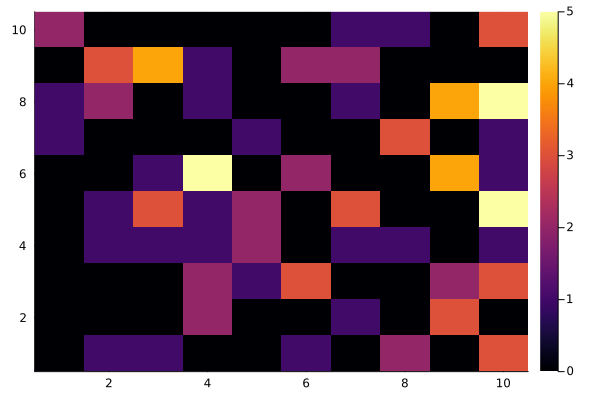

In [9]:
using Plots

function wealth_distr(data, model, n)
    W = zeros(Int, size(model.space))
    for row in eachrow(filter(r -> r.step == n, data)) # iterate over rows at a specific step
        W[row.pos...] += row.wealth
    end
    return W
end

W1 = wealth_distr(adata, model2D, 1)
Plots.heatmap(W1)

In [16]:
models = [wealth_model_2D(M=i) for i in 5:5:100]
ensemblerun!(models, agent_step_2d!, dummystep, 10; adata = adata, mdata = [gini])

MethodError: MethodError: no method matching init_agent_dataframe(::StandardABM{GridSpace{2, true}, WealthInSpace, typeof(Agents.Schedulers.randomly), Nothing, Random.TaskLocalRNG}, ::DataFrames.DataFrame)

Closest candidates are:
  init_agent_dataframe(::Any, !Matched::Nothing)
   @ Agents ~/.julia/packages/Agents/06AXy/src/simulations/collect.jl:323
  init_agent_dataframe(::AgentBasedModel{S, A}, !Matched::Vector{<:Tuple}) where {S, A<:AbstractAgent}
   @ Agents ~/.julia/packages/Agents/06AXy/src/simulations/collect.jl:466
  init_agent_dataframe(::AgentBasedModel{S, A}, !Matched::AbstractArray) where {S, A<:AbstractAgent}
   @ Agents ~/.julia/packages/Agents/06AXy/src/simulations/collect.jl:333
